### GTEx v8 *cis*-eQTL mapping with tensorQTL

The [GTEx v8](https://www.science.org/doi/10.1126/science.aaz1776) eQTLs available from the [GTEx Portal](https://gtexportal.org/) were mapped using FastQTL. This notebook illustrates how to reproduce the results using TensorQTL. 

*Note*: due to differences in processing (batching of calculations), no equivalent random seed can be set to obtain identical results from the permutations, but the results should closely match, with differences limited to eGenes close to the FDR threshold, as illustrated below.

#### Input files

The expression and covariate matrices can be downloaded from the [GTEx Portal](https://gtexportal.org/home/datasets), under `GTEx Analysis V8 > Single-Tissue cis-QTL Data`, in the archives `GTEx_Analysis_v8_eQTL_expression_matrices.tar` and `GTEx_Analysis_v8_eQTL_covariates.tar.gz`.

The VCF must be obtained from dbGaP/AnVIL. Please see the GTEx Portal for [instructions on accessing GTEx protected data]((https://gtexportal.org/home/protectedDataAccess)).

On AnVIL, the VCF can be found in the [V8 workspace](https://anvil.terra.bio/#workspaces/anvil-datastorage/AnVIL_GTEx_V8_hg38), in `GTEx_Analysis_2017-06-05_v8_WGS_VCF_files/GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_Analysis_Freeze.SHAPEIT2_phased.MAF01.vcf.gz`.

The v8 eQTL results used for comparisons below can also be obtained from the GTEx Portal, in `GTEx_Analysis_v8_eQTL.tar` and full summary statistics can be download [here](https://console.cloud.google.com/storage/browser/gtex-resources).



In [1]:
import pandas as pd
import numpy as np
import tensorqtl
from tensorqtl import genotypeio, cis, post
import qtl.plot

import matplotlib.pyplot as plt
plt.rcParams.update({'font.family': 'Helvetica', 'svg.fonttype':'none', 'pdf.fonttype':42})

In [2]:
plink_prefix_path = '/resources/vcfs/GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_Analysis_Freeze.SHAPEIT2_phased.MAF01'
pr = genotypeio.PlinkReader(plink_prefix_path)
genotype_df = pr.load_genotypes()
variant_df = pr.bim.set_index('snp')[['chrom', 'pos']]


Mapping files: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:20<00:00,  6.91s/it]


In [3]:
tissue_id = 'Brain_Cortex'
covariates_df = pd.read_csv(f"/resources/V8_release/GTEx_Analysis_v8_eQTL_covariates/{tissue_id}.v8.covariates.txt",
                            sep='\t', index_col=0).T
phenotype_df, phenotype_pos_df = tensorqtl.read_phenotype_bed(
    f'/resources/V8_release/GTEx_Analysis_v8_eQTL_expression_matrices/{tissue_id}.v8.normalized_expression.bed.gz')

#### Permutations

In [4]:
# run permutations and compute q-values
cis_df = cis.map_cis(genotype_df, variant_df, phenotype_df, phenotype_pos_df,
                     covariates_df=covariates_df, seed=3042235018, 
                     warn_monomorphic=False)
post.calculate_qvalues(cis_df, fdr=0.05, qvalue_lambda=0.85)

cis-QTL mapping: empirical p-values for phenotypes
  * 205 samples
  * 24849 phenotypes
  * 38 covariates
  * 10770860 variants
  * using seed 3042235018
  * checking phenotypes: 24849/24849
  * computing permutations
    processing phenotype 24849/24849
  Time elapsed: 27.25 min
done.
Computing q-values
  * Number of phenotypes tested: 24849
  * Correlation between Beta-approximated and empirical p-values: 0.9999
  * Calculating q-values with lambda = 0.850
  * Proportion of significant phenotypes (1-pi0): 0.63
  * QTL phenotypes @ FDR 0.05: 9072
  * min p-value threshold @ FDR 0.05: 0.0488264


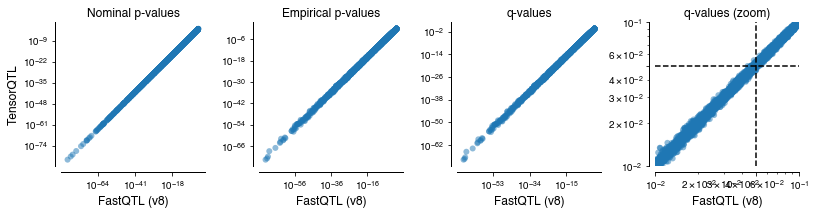

In [5]:
# load V8 results and plot comparisons
egenes_v8_df = pd.read_csv(f'/resources/V8_release/GTEx_Analysis_v8_eQTL/{tissue_id}.v8.egenes.txt.gz',
                           sep='\t', index_col=0)

args = {'ec':'none', 'alpha':0.5}
ax = qtl.plot.get_axgrid(1, 4)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].scatter(egenes_v8_df['pval_nominal'], cis_df['pval_nominal'], **args)
ax[0].set_title('Nominal p-values', fontsize=12)
ax[0].set_xlabel('FastQTL (v8)', fontsize=12)
ax[0].set_ylabel('TensorQTL', fontsize=12)

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].scatter(egenes_v8_df['pval_beta'], cis_df['pval_beta'], **args)
ax[1].set_title('Empirical p-values', fontsize=12)
ax[1].set_xlabel('FastQTL (v8)', fontsize=12)

ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].scatter(egenes_v8_df['qval'], cis_df['qval'], **args)
ax[2].set_title('q-values', fontsize=12)
ax[2].set_xlabel('FastQTL (v8)', fontsize=12);

# zoom on FDR threshold
ax[3].set_xscale('log')
ax[3].set_yscale('log')
ax[3].scatter(egenes_v8_df['qval'], cis_df['qval'], **args)
ax[3].set_title('q-values (zoom)', fontsize=12)
ax[3].set_xlabel('FastQTL (v8)', fontsize=12);
b = [0.01, 0.1]
ax[3].plot(b, [0.05, 0.05], 'k--')
ax[3].plot([0.05, 0.05], b, 'k--')
ax[3].set_xlim(b)
ax[3].set_ylim(b)
ax[3].set_xticks([0.01, 0.05, 0.1])
ax[3].set_yticks([0.01, 0.05, 0.1]);

In [6]:
# eGenes overlap
egenes_v8 = egenes_v8_df[egenes_v8_df['qval'] <= 0.05].index
egenes = cis_df[cis_df['qval'] <= 0.05].index
ix = egenes[egenes.isin(egenes_v8)]
print(f"eGenes, v8 (all biotypes):   {len(egenes_v8)}")
print(f"eGenes, rep. (all biotypes): {len(egenes)}")
print(f"  * intersection:            {len(ix)} ({len(ix)/len(egenes_v8)*100:.1f}%)")

eGenes, v8 (all biotypes):   9082
eGenes, rep. (all biotypes): 9072
  * intersection:            9047 (99.6%)


#### Nominal associations

In [7]:
# nominal mode (limit to one chromosome for illustration purposes)
chrom = 'chr9'
m = phenotype_pos_df['chr'] == chrom
cis.map_nominal(genotype_df, variant_df, phenotype_df[m], phenotype_pos_df[m], tissue_id,
                covariates_df=covariates_df, output_dir='/mnt/disks/scratch/tmp/')
nominal_df = pd.read_parquet(f'/mnt/disks/scratch/tmp/Brain_Cortex.cis_qtl_pairs.{chrom}.parquet')

cis-QTL mapping: nominal associations for all variant-phenotype pairs
  * 205 samples
  * 986 phenotypes
  * 38 covariates
  * 10770860 variants
  * checking phenotypes: 986/986
  * Computing associations
    Mapping chromosome chr9
    processing phenotype 986/986
    time elapsed: 0.19 min
    * writing output
done.


In [8]:
# load V8 summary statistics
nominal_v8_df = pd.read_parquet(
    f"gs://gtex-resources/GTEx_Analysis_v8_QTLs/GTEx_Analysis_v8_eQTL_all_associations/{tissue_id}.v8.allpairs.parquet")

# subset chr9
nominal_v8_df = nominal_v8_df[nominal_v8_df['variant_id'].str.startswith(chrom)]
nominal_v8_df.reset_index(drop=True, inplace=True)

# check that outputs are identical
assert nominal_v8_df['gene_id'].equals(nominal_df['phenotype_id'])
assert nominal_v8_df['variant_id'].equals(nominal_df['variant_id'])
assert nominal_v8_df['tss_distance'].equals(nominal_df['tss_distance'])


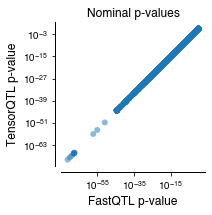

In [9]:
# plot p-values
ax = qtl.plot.get_axgrid(1, 1)[0]
ax.set_xscale('log')
ax.set_yscale('log')
ax.scatter(nominal_v8_df['pval_nominal'], nominal_df['pval_nominal'], **args)
ax.set_title('Nominal p-values', fontsize=12)
ax.set_xlabel('FastQTL p-value', fontsize=12)
ax.set_ylabel('TensorQTL p-value', fontsize=12);